 # Nikonov, 2021-12-13 #

In [ ]:
!apt install sox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrwb0 amd64 0.1.3-2.1 [45.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main a

### Baseline commands recognition (2-5 points)

We're now going to train a classifier to recognize voice. More specifically, we'll use the [Speech Commands Dataset] that contains around 30 different words with a few thousand voice records each.

In [ ]:
import os
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import librosa
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torchvision.transforms as T
from scipy.io import wavfile
import IPython.display as ipd

device = 'cuda'

In [ ]:
datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2021-10-24 14:31:22--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.13.128, 2a00:1450:400c:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.13.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  88.0MB/s    in 18s     

2021-10-24 14:31:41 (76.8 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


In [ ]:
!sox --info speech_commands/bed/00176480_nohash_0.wav


Input File     : 'speech_commands/bed/00176480_nohash_0.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



### Нарисуем спектрограмму "right"

In [ ]:
def show_spectrogram(wav_path):

    # Read the wav file (mono)
    samplingFrequency, signalData = wavfile.read(wav_path)

    plt.subplot(211)
    plt.title('Spectrogram of a wav file')

    plt.plot(signalData)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude') 

    plt.subplot(212)
    plt.specgram(signalData,Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.show()
    return ipd.Audio(wav_path)

In [ ]:
show_spectrogram('/content/speech_commands/right/00b01445_nohash_0.wav')

### Подготовка данных

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm
import joblib as jl

classes = ("left", "right", "up", "down", "stop")

def preprocess_sample(filepath, max_length=150):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))
spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  


100%|██████████| 11834/11834 [07:32<00:00, 26.13it/s]


### Модель с 2d-свертками

In [ ]:
# X.shape
X_r = X[:,None,:,:]
X_r.shape

(11834, 1, 150, 128)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_r, y, random_state=42)

In [ ]:
batch_size = 16

tensor_x = torch.Tensor(X_train)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

### Функция обучения модели
__Параметры:__
* модель
* данные для обучения
* количество эпох

Функция возвращает лосс

In [ ]:
def model_train(model, trainloader, epochs):
  total_step = len(trainloader)
  losses, epoch_losses = [], []
  for epoch in range(epochs):  # loop over the dataset multiple times
      model.train()
      running_loss = 0.0
      epoch_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()     
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          epoch_loss += loss.item()
          if (i+1) % 50 == 0:    # print every 50 mini-batches
              print('Epoch [{}/{}], Step [{}/{}], loss: {:.3f}'
                  .format(epoch, epochs, i+1, total_step, running_loss / 50))
              running_loss = 0.0
      epoch_losses.append(epoch_loss)


  print('Finished Training')
  return epoch_losses

### Модель

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net2d(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define your layers here
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        # self.bn1 = nn.BatchNorm2D(16)

        self.conv2 = nn.Conv2d(16, 32, 5)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(4, 2)

        self.conv3 = nn.Conv2d(32, 64, 5)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(6, 2)

        self.conv4 = nn.Conv2d(64, 128, 5)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(6, 2)


        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256, 64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(64, 5)

    def forward(self, x):
        # TODO: apply your layers here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        return F.softmax(x)


net2d = Net2d().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2d.parameters(), lr=0.003)#, momentum=0.9)

### Предсказания на тестовых данных

Посмотрим accuracy в т.ч поклассово

In [ ]:
def model_predict(model, testloader):
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  correct = 0
  total = 0

  # again no gradients needed
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          _, predictions = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predictions == labels).sum().item()
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print('Total accuracy: %d %%' % (
      100 * correct / total))
  return

In [ ]:
epoch_losses = model_train(net2d, trainloader, 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [0/20], Step [50/555], loss: 1.587
Epoch [0/20], Step [100/555], loss: 1.569
Epoch [0/20], Step [150/555], loss: 1.542
Epoch [0/20], Step [200/555], loss: 1.531
Epoch [0/20], Step [250/555], loss: 1.476
Epoch [0/20], Step [300/555], loss: 1.477
Epoch [0/20], Step [350/555], loss: 1.416
Epoch [0/20], Step [400/555], loss: 1.452
Epoch [0/20], Step [450/555], loss: 1.436
Epoch [0/20], Step [500/555], loss: 1.388
Epoch [0/20], Step [550/555], loss: 1.427
Epoch [1/20], Step [50/555], loss: 1.402
Epoch [1/20], Step [100/555], loss: 1.330
Epoch [1/20], Step [150/555], loss: 1.382
Epoch [1/20], Step [200/555], loss: 1.354
Epoch [1/20], Step [250/555], loss: 1.320
Epoch [1/20], Step [300/555], loss: 1.367
Epoch [1/20], Step [350/555], loss: 1.314
Epoch [1/20], Step [400/555], loss: 1.338
Epoch [1/20], Step [450/555], loss: 1.357
Epoch [1/20], Step [500/555], loss: 1.334
Epoch [1/20], Step [550/555], loss: 1.307
Epoch [2/20], Step [50/555], loss: 1.384
Epoch [2/20], Step [100/555], loss: 1

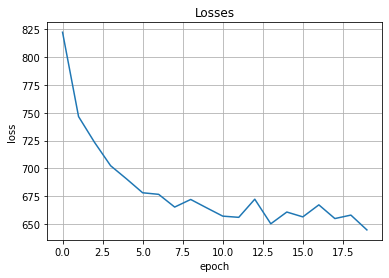

In [ ]:
plt.plot(epoch_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.title('Losses')

In [ ]:
model_predict(net2d, testloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy for class left  is: 78.9 %
Accuracy for class right is: 81.7 %
Accuracy for class up    is: 78.6 %
Accuracy for class down  is: 83.0 %
Accuracy for class stop  is: 75.0 %
Total accuracy: 79 %
